# DMQC Report: WMO 4900637

## Current status and metadata: 

- APEX float active from February 2005 to August 2009, completing 164 cycles
- In the mid-North Pacific
- In 'A' mode, gain of 1.013427 applied
- Mean gain of 1.06816

In [ ]:
bgc.configure.configure()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib.dates import datestr2num
import matplotlib.pyplot as plt

from pathlib import Path
import numpy as np
import pandas as pd
import bgcArgoDMQC as bgc

wmo = 4900637 # insert WMO number here
fig_path = Path('figures/') / f'{wmo}' # where to save figures
fig_path.mkdir(exist_ok=True)
bgc.io.get_argo(wmo, local_path=bgc.io.Path.ARGO_PATH) # download the data to ensure you have up to date files
flt = bgc.sprof(wmo)
flt.clean()
gains = flt.calc_gains(ref='WOA') # calculate gain, can change to ref='NCEP' if in-air data is available
print(np.nanmean(gains))

## DOXY Audit Status

- If the float has any profiles present in the DOXY audit, which are they are why?
- Likely will usually be left empty/deleted

In [19]:
audit_file = list(Path('../Audit/').glob('DOXY_WOA*.TXT'))[-1]
df = pd.read_csv(audit_file, sep='\t', header=25)
df = df.loc[df.WMO == wmo]
df['date'] = [datestr2num(t) for t in df['profile date']]
print(df)

       DAC             PI SPROF DATE_UPDATE DATA MODE      WMO  cycle  \
1818  meds  Blair Greenan    09/03/24 23:40         A  4900637     87   
1819  meds  Blair Greenan    09/03/24 23:40         A  4900637     88   
1820  meds  Blair Greenan    09/03/24 23:40         A  4900637     89   
1821  meds  Blair Greenan    09/03/24 23:40         A  4900637     90   

        profile date     lon    lat  WOA T  ...   PRES   TEMP   PSAL  \
1818  07/13/07 11:55 -128.29  46.62  15.29  ...  11.13  14.77  12.22   
1819  07/23/07 11:39 -128.36  46.66  15.80  ...  11.23  15.40  12.45   
1820  08/02/07 11:22 -128.35  46.67  16.28  ...  11.03  16.58  12.10   
1821  08/12/07 12:13 -128.31  46.62  16.80  ...  10.97  16.55  12.27   

      flt O2 %sat  flt O2adj %sat  WOA G_raw  WOA G_adj  Z_WOAraw  Z_WOAadj  \
1818        91.62           92.86       1.15       1.13      1.89       6.8   
1819        91.99           93.25       1.14       1.12      1.71       6.4   
1820        90.39           91.61   

## Visual QC

- Visualize the float and reference surface saturations, as well as the profiles. 
- Observe if DOXY data is set to '3' as it should be or if it is '1' or '2'. 
- Try to note cycles or other identifying features of potentially problematic profiles.

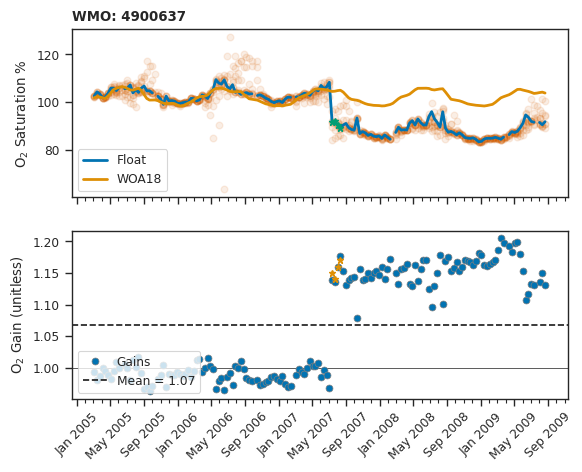

In [20]:
g = flt.plot('gain', ref='WOA')
g.axes[0].set_title(f'WMO: {wmo}', loc='left', fontweight='bold')
g.axes[0].plot(df['date'], df['flt O2 %sat'], '*')
g.axes[1].plot(df['date'], df['WOA G_raw'], '*', zorder=3)
g.axes[0].plot(flt.df.SDN.loc[flt.df.PRES < 50], flt.df.O2Sat.loc[flt.df.PRES < 50], 'o', zorder=0, alpha=0.1)
g.fig.savefig(fig_path / 'gain_initial.png', bbox_inches='tight', dpi=250)

Figure 1: Top panel: Float oxygen percent saturation (blue line) compared to WOA percent saturation (orange line), with DOXY audit flagged cycle percent saturation (green stars, if applicable) and raw float percent saturation (orange circles). Bottom panel: calculated gains (blue dots) and flagged gains from DOXY audit (orange stars).

Notes: [notes on what this figure tells you here] 

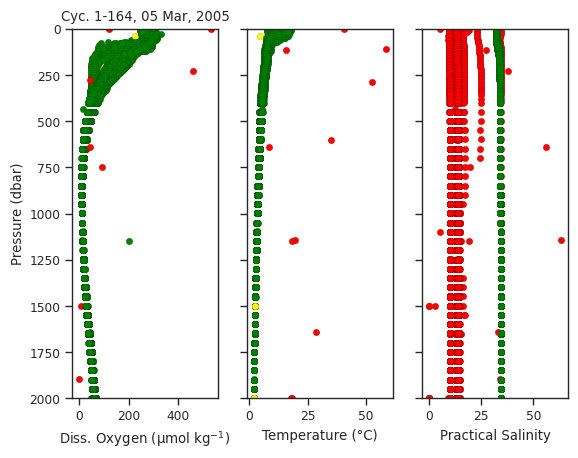

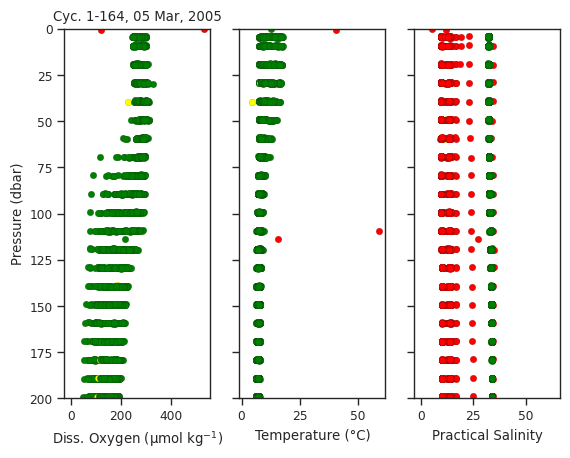

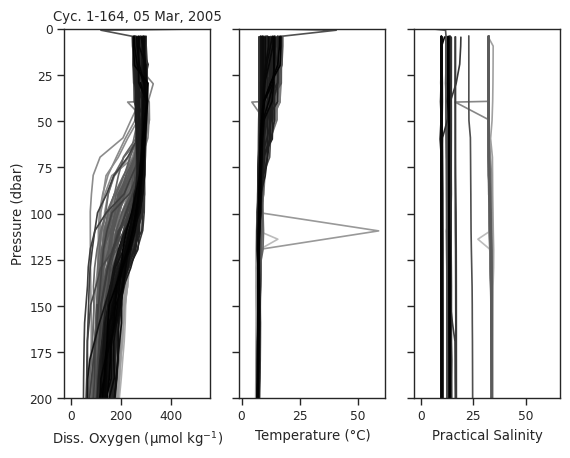

In [21]:
flt.reset()
g = flt.plot('qcprofiles', varlist=['DOXY', 'TEMP', 'PSAL'])
g.fig.savefig(fig_path / 'qcprofiles.png', bbox_inches='tight', dpi=250)
g = flt.plot('qcprofiles', varlist=['DOXY', 'TEMP', 'PSAL'])
g.axes[0].set_ylim((200,0))
g.fig.savefig(fig_path / 'qcprofiles_shallow.png', bbox_inches='tight', dpi=250)
g = flt.plot('profiles', varlist=['DOXY', 'TEMP', 'PSAL'])
g.axes[0].set_ylim((200,0))
g.fig.savefig(fig_path / 'profiles_shallow.png', bbox_inches='tight', dpi=250)

Figures 2,3: Profiles coloured by QC flag (1-2, green, 3, yellow, 4, red) on difference depth scales.

Notes: [notes on what this figure tells you here] 

## Flag bad data, recalculate gain

- Using the plots above (and likely some more specific plots, made on a case-by-case basis), flag bad DOXY data as 4. 
- After flagging bad data, re-clean the data and re-calculate the gains.

Updating DOXY_QC on 0 levels
Updating DOXY_ADJUSTED_QC on 0 levels

Calculating gains using WOA surface data and float O2 percent saturation...
1.0681610082966675


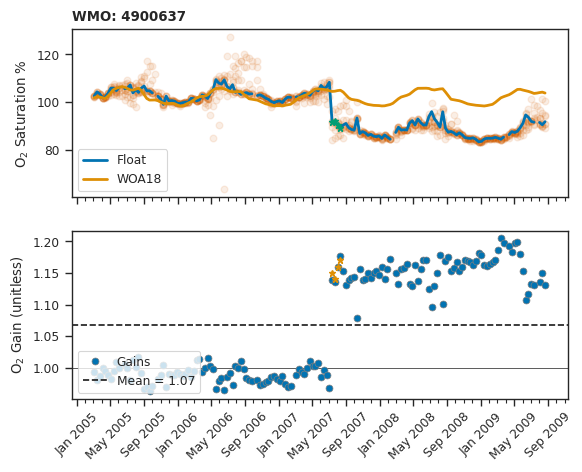

In [22]:
bad_oxygen = [] # index defining where the oxygen should be flagged as bad
flt.update_field('DOXY_QC', 4, where=bad_oxygen)
flt.update_field('DOXY_ADJUSTED_QC', 4, where=bad_oxygen)
flt.clean()
new_gains = flt.calc_gains(ref='WOA')
print(np.nanmean(new_gains))

g = flt.plot('gain', ref='WOA')
g.axes[0].set_title(f'WMO: {wmo}', loc='left', fontweight='bold')
g.axes[0].plot(df['date'], df['flt O2 %sat'], '*')
g.axes[1].plot(df['date'], df['WOA G_raw'], '*', zorder=3)
g.axes[0].plot(flt.df.SDN.loc[flt.df.PRES < 50], flt.df.O2Sat.loc[flt.df.PRES < 50], 'o', zorder=0, alpha=0.1)
g.fig.savefig(fig_path / 'gain_final.png', bbox_inches='tight', dpi=250)

Figure x: Repeated gain plot with bad data removed.

## Update Fields and Export

- DOXY should be 3 by default, but many old floats have 1 or 0. Though it will be redundant in some cases, make sure DOXY_QC is not good.
- Apply the gain to calculate DOXY_ADJUSTED. 
- Fill in DOXY_ADJUSTED_ERROR with an appropriate fixed value.
- Fill in DOXY_ADJUSTED_QC. 
- Make sure DOXY_ADJUSTED and DOXY_ADJUSTED_ERROR are `FillValue` wherever DOXY_ADJUSTED_QC is bad.
- Export the D-mode files. During export, HISTORY parameters will be filled as well as SCIENTIFIC_CALIB parameters using some default structures and user info set by calling `bgc.configure.configure()`.

In [23]:
# make sure DOXY_QC is 3 instead of 0,1,2
flt.update_field('DOXY_QC', 3, where=flt.DOXY_QC.isin([0, 1, 2]))
# apply gain and calculate error
flt.update_field('DOXY_ADJUSTED', flt.gain*flt.DOXY)
flt.update_field('DOXY_ADJUSTED_ERROR', bgc.calc_fixed_doxy_adjusted_error(flt.PSAL, flt.TEMP, flt.PRES))
# fill in DOXY_ADJUSTED_QC appropriately
flt.update_field('DOXY_ADJUSTED_QC', flt.DOXY_QC)
flt.update_field('DOXY_ADJUSTED_QC', 1, where=flt.DOXY_ADJUSTED_QC.isin([0, 3]))
flt.update_field('DOXY_ADJUSTED_QC', 4, where=flt.TEMP_ADJUSTED_QC == 4)
flt.update_field('DOXY_ADJUSTED_QC', 3, where=flt.PSAL_ADJUSTED_QC == 4)
# make sure the data is FillValues where adjusted values are still bad
flt.set_fillvalue('DOXY_ADJUSTED', where=flt.DOXY_ADJUSTED_QC == 4)
flt.set_fillvalue('DOXY_ADJUSTED_ERROR', where=flt.DOXY_ADJUSTED_QC == 4)

Updating DOXY_QC on 11465 levels
Updating DOXY_ADJUSTED on all levels
Updating DOXY_ADJUSTED_ERROR on all levels
Updating DOXY_ADJUSTED_QC on all levels
Updating DOXY_ADJUSTED_QC on 11497 levels
Updating DOXY_ADJUSTED_QC on 11 levels
Updating DOXY_ADJUSTED_QC on 5265 levels
Updating DOXY_ADJUSTED on 4 levels
Updating DOXY_ADJUSTED_ERROR on 4 levels


In [13]:
# export the files
flt.export_files(data_mode='D')

Working on D-mode file meds/4900637/profiles/BD4900637_001.nc...

KeyError: 'operator'